In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Allostatic Load Calculation/Output')
cur_date = "111424"

library(readxl)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ordinalNet)
library(reshape2)
library(rstatix)
library(car)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpubr)
library(rlang)
library(wesanderson)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_061424.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubri

In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,1
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,1
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_18_B_1,0.4683470
2,Cortisol,CS_F_20_W_2,0.8342112
3,Cortisol,CS_F_20_W_3,0.1603803
4,Cortisol,CS_F_21_W_4,0.4583014
5,Cortisol,CS_M_21_W_5,0.3867217
6,Cortisol,CS_F_22_W_6,0.1712352


Calculating allostatic load (AL) scores for each subject, which serves as a measure for stress.

1. **Acute Stress**

    In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 acute stress biomarkers (Noradrenaline, epinephrine, and cortisol).
    

3. **Chronic (secondary/tertiary) Stress**
   
    No deriving of ordinal weights in this analysis, since we don't have an outcome that we measured associated with chronic stress. We'll include 4 chronic stress biomarkers (CRP, HbA1c, Fibrnogen, and HDL). 
    

5. **Overall AL**
   
    Summing the acute and chronic AL scores.

# Acute Sress
Starting by combining the dataframes.

In [3]:
# creating a vector for variables that increase acute stress
acute_biomarkers = c('Cortisol','Noradrenaline','Epinephrine')

ordinal_regression = function(dataset){
    # """
    # Using oridinal regression to predict blood pressure category using mediator scores.
    # :param (input): acute mediator score dfs
    # :output: df of weights for each mediator
    # """
    
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining acute biomarkers only
        filter(Variable %in% acute_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:10,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.3867217,0.9216080,0.02133767,N
CS_M_24_W_8,0.4378417,0.5058597,0.02155180,N
CS_M_25_W_10,0.2932014,0.8479016,0.18657420,1
CS_M_28_W_16,0.2416750,0.5058597,0.48633181,N
CS_M_29_W_17,0.5472276,0.3352036,0.35658497,1
CS_F_31_B_21,0.3620846,0.2770528,0.16448963,N


## Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [4]:
table(reg_df$BP_Classification)


 1  2  E  N 
11  4  4 15 

The elevated and stage 2 classes are on the smaller side with 4 subjects. There weren't enough observations of either class to perform SMOTE; therefore, the blood pressure classes will be condensed in two different ways:

+ **3 classes**: Normal subjects, at risk (elevated) subjects, and hypertensive subjects (formerly stage 1 and stage 2 subjects)
+ **2 classes**: Normal subjects and hypertensive subjects (formerly elevated, stage 1, and stage 2 subjects)

In [5]:
three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification)) 

# turning BP into a factor
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "E", "H"))
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "H"))

In [6]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  H 
15 19 


 N  E  H 
15  4 15 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [7]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:4], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9389878,5.752138e-02,Shapiro-Wilk normality test,Normal


Only 1 variable was normally distributed; therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [8]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,1
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,1
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


In [9]:
do.call(rbind.data.frame, apply(pslog2_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8080826,3.687146e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9528941,1.498883e-01,Shapiro-Wilk normality test,Normal
Epinephrine,0.9413655,6.770597e-02,Shapiro-Wilk normality test,Normal


Now we have 2 out of 3 variables that are normally distributed.

In [10]:
# need to use the pslog2 data
three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(three_reg_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,H
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,H
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


## Summary Statistics

Determining if there are any significant differences between the features for each outcome class.

In [11]:
# 3 class outcome
inner_join(three_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "aov",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`
Warning for variable 'Smoking_Status':
simpleWarning in stats::chisq.test(x = c("CS", "CS", "CS", "CS", "CS", "CS", "CS", : Chi-squared approximation may be incorrect

Warning for variable 'Sex':
simpleWarning in stats::chisq.test(x = c("M", "M", "M", "M", "M", "F", "M", "M", : Chi-squared approximation may be incorrect

Warning for variable 'Race':
simpleWarning in stats::chisq.test(x = c("W", "W", "W", "W", "W", "B", "W", "B", : Chi-squared approximation may be incorrect



**Characteristic**,**N**,"**N**, N = 15","**E**, N = 4","**H**, N = 15",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.18),0.34 (0.08),0.42 (0.15),0.4
Noradrenaline,34,0.49 (0.30),0.41 (0.19),0.47 (0.32),0.9
Epinephrine,34,0.26 (0.17),0.25 (0.10),0.19 (0.15),0.5
Smoking_Status,34,NA,NA,NA,0.2
CS,NA,6 (40%),1 (25%),10 (67%),NA
NS,NA,9 (60%),3 (75%),5 (33%),NA
Sex,34,NA,NA,NA,0.6
F,NA,11 (73%),2 (50%),9 (60%),NA
M,NA,4 (27%),2 (50%),6 (40%),NA


In [12]:
# two class outcome
inner_join(two_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "t.test",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`


**Characteristic**,**N**,"**N**, N = 15","**H**, N = 19",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.18),0.40 (0.14),0.3
Noradrenaline,34,0.49 (0.30),0.45 (0.29),0.7
Epinephrine,34,0.26 (0.17),0.21 (0.14),0.3
Smoking_Status,34,NA,NA,0.5
CS,NA,6 (40%),11 (58%),NA
NS,NA,9 (60%),8 (42%),NA
Sex,34,NA,NA,0.6
F,NA,11 (73%),11 (58%),NA
M,NA,4 (27%),8 (42%),NA


## Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 biomarkers. Just doing this to get weights of these variables.

In [13]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) 
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)

three_weights_df
two_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.73498880
Cortisol,0.22212979
Noradrenaline,0.04288141


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.52656569
Cortisol,0.44720887
Noradrenaline,0.02622544


## Ordinal Weights Visualization

In [14]:
# creating 1 df
weights_df = cbind(rbind(three_weights_df, two_weights_df), 
                   # adding a col that specificies the number of classes of blood pressure
                   Blood_Pressure_Class_No = c(rep(3, length(three_weights_df$Variable)), 
                                               rep(2, length(three_weights_df$Variable)))) %>% 
    # getting the circle positions for the text labels
    group_by(Blood_Pressure_Class_No) %>%
    mutate(csum = rev(cumsum(rev(Coefficient))), 
         pos = Coefficient/2 + lead(csum, 1),
         pos = if_else(is.na(pos), Coefficient/2, pos))

head(weights_df)

Variable,Coefficient,Blood_Pressure_Class_No,csum,pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epinephrine,0.73498880,3,1.00000000,0.63250560
Cortisol,0.22212979,3,0.26501120,0.15394630
Noradrenaline,0.04288141,3,0.04288141,0.02144070
Epinephrine,0.52656569,2,1.00000000,0.73671715
Cortisol,0.44720887,2,0.47343431,0.24982987
Noradrenaline,0.02622544,2,0.02622544,0.01311272


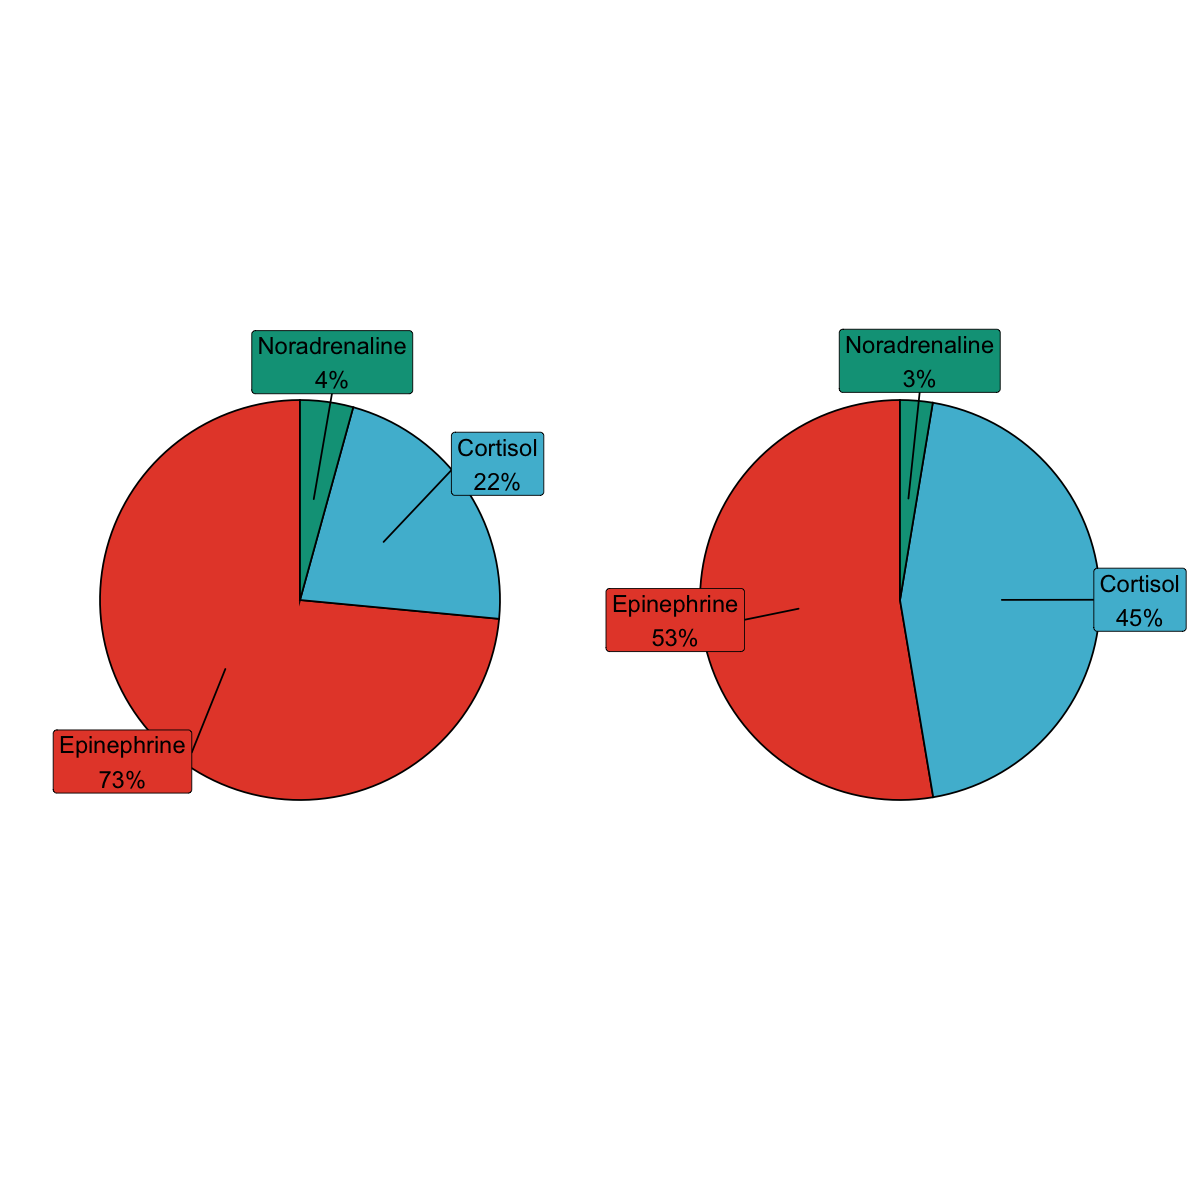

In [15]:
options(repr.plot.width=10, repr.plot.height=10) #changing size

Figure1a = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 3), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 3), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  scale_fill_npg()

col_palette = pal_npg()(7)

Figure1b = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 2), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 2), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") +  
  scale_fill_manual(values = col_palette[c(1,2,3)])

Figure1 = plot_grid(Figure1a, Figure1b)
Figure1

Based on these results, epinephrine had the largest contribution to blood pressure classification in both cases. 

## Acute Stress Summation

Now that we have these weights from the ordinal regression, we'll calculate stress scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 3 acute biomarkers (cortisol, noradrenaline, epinephrine). AL scores will be calculated for all 63 subjects not just the 34 with BP data. The formula looks like...

Allostatic Load = Acute Stress + Chronic Stress

Acute Stress = Cortisol ordinal weight * Cortisol score + Epinephrine ordinal weight * Epinephrine score...

In [16]:
acute_stress = function(weights_df){
    # """
    # Calculating acute stress scores for each subject
    # :param (input): ordinal weights dfs
    # :output: acute stress scores df
    # """
    
    # combining the mediator scores for all 63 subjects with the ordinal weights into one dataframe
    wider_weights_df = mediator_scores_df %>%
        filter(Variable %in% acute_biomarkers) %>%
        mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
        dcast(Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        dplyr::select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Acute_Stress = apply(multiplication_df, 2, sum)) %>%
        arrange(-Acute_Stress) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
three_acute_stress_df = acute_stress(three_weights_df)
two_acute_stress_df = acute_stress(two_weights_df)

head(three_acute_stress_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Acute_Stress
,<chr>,<dbl>
1,NS_M_28_W_51,0.8163546
2,NS_F_23_W_41,0.5511180
3,CS_M_28_W_16,0.5149280
4,NS_F_21_W_38,0.4941965
5,CS_M_29_W_17,0.4811360
6,NS_F_32_B_57,0.4459038


# Chronic Stress Summation

This involves normalizing their mediator scores, multiplying the mediators by 0.25 (HDL by -0.25 since it's considered protective against atherosclerotic risk), summing them to get the chronic stress score, and adding the minimum value (~ -0.11) to make all the values positive.

Chronic Stress = 0.25 * Hba1c mediator Score + (-0.25 * HDL mediator score)...

In [17]:
chronic_biomarkers = c('Hba1c','CRP', 'HDL','Fibrinogen')

chronic_stress_df = mediator_scores_df %>%
    # filtering for chronic biomarkers
    filter(Variable %in% chronic_biomarkers) %>%
    # normalizing
    mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
    # rescaling so that these numbers fall between 0 and 1 by multiplying by 0.25
    # making HDL negative
    mutate(Mediator_Score = ifelse(Variable == "HDL", -0.25 * Mediator_Score , 0.25 * Mediator_Score)) %>%
    # summing for each subject
    group_by(Subject_ID) %>%
    summarize(Summed_Score = sum(Mediator_Score)) %>%
    # adding the minimum value to each score to make the numbers positive 
    mutate(Chronic_Stress = Summed_Score + abs(min(Summed_Score))) %>%
    dplyr::select(-Summed_Score) %>%
    arrange(-Chronic_Stress)

head(chronic_stress_df)

Subject_ID,Chronic_Stress
<chr>,<dbl>
NS_F_42_B_62,0.6437062
CS_F_39_W_32,0.5696550
NS_F_28_B_53,0.5671195
NS_F_35_B_59,0.5395632
NS_F_27_B_50,0.5322398
NS_F_23_W_41,0.4644919


# Overall AL

Summing the acute and chronic stress scores. These scores range from 0-2.

In [18]:
allostatic_three_df = inner_join(three_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

allostatic_two_df = inner_join(two_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

head(allostatic_three_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load
,<chr>,<dbl>,<dbl>,<dbl>
1,NS_M_28_W_51,0.8163546,0.06229179,0.8786464
2,NS_F_23_W_41,0.5511180,0.46449188,1.0156099
3,CS_M_28_W_16,0.5149280,0.21225869,0.7271867
4,NS_F_21_W_38,0.4941965,0.32846096,0.8226575
5,CS_M_29_W_17,0.4811360,0.24664702,0.7277830
6,NS_F_32_B_57,0.4459038,0.39174739,0.8376512


Before testing for statistical differences, let's check the ANOVA assumptions: normality and homogeneity of variance.

In [19]:
# seeing if this data is normal
do.call(rbind.data.frame, apply(allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

do.call(rbind.data.frame, apply(allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9125035,0.000274726,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.015075439,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9573137,0.028453470,Shapiro-Wilk normality test,Non-normal


,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9247402,0.0008747202,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.0150754390,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9634803,0.0585841441,Shapiro-Wilk normality test,Normal


These data aren't normally distributed. However, I'm moving forward and creating the dataframe necessary to run the variance tests and anova tests.

In [20]:
# adding in demographic info for each subject
three_df = inner_join(allostatic_three_df, subject_info_df[,c(3,5,6,8)])
two_df = inner_join(allostatic_two_df, subject_info_df[,c(3,5,6,8)])


# converting into factors
three_df$Smoking_Status = factor(three_df$Smoking_Status, levels = c("NS", "CS"))
three_df$Sex = factor(three_df$Sex)
three_df$Race = factor(three_df$Race, levels = c("W", "B"))
two_df$Smoking_Status = factor(two_df$Smoking_Status, levels = c("NS", "CS"))
two_df$Sex = factor(two_df$Sex)
two_df$Race = factor(two_df$Race, levels = c("W", "B"))

head(three_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,NS_M_28_W_51,0.8163546,0.06229179,0.8786464,NS,M,W
2,NS_F_23_W_41,0.5511180,0.46449188,1.0156099,NS,F,W
3,CS_M_28_W_16,0.5149280,0.21225869,0.7271867,CS,M,W
4,NS_F_21_W_38,0.4941965,0.32846096,0.8226575,NS,F,W
5,CS_M_29_W_17,0.4811360,0.24664702,0.7277830,CS,M,W
6,NS_F_32_B_57,0.4459038,0.39174739,0.8376512,NS,F,B


Using a levene's test to assess homogeneity of variance.

In [21]:
leveneTest(Allostatic_Load ~ Sex, data = three_df)[1,3]
leveneTest(Allostatic_Load ~ Race, data = three_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status, data = three_df)[1,3]
leveneTest(Allostatic_Load ~ Sex, data = two_df)[1,3]
leveneTest(Allostatic_Load ~ Race, data = two_df)[1,3]
leveneTest(Allostatic_Load ~ Smoking_Status, data = two_df)[1,3]

[1] 0.1849412

[1] 0.8247529

[1] 0.006445645

[1] 0.06570792

[1] 0.9659931

[1] 0.006841611

There are differences in variances for sex, smoking status, as well as the stratified_variable betwen sex and smoking status.

In [22]:
# looking at counts for each variable
# smoking status
table(three_df[,c(5)])
chisq.test(table(three_df[,c(5)]))
# sex
table(three_df[,c(6)])
chisq.test(table(three_df[,c(6)]))
# race
table(three_df[,c(7)])
chisq.test(table(three_df[,c(7)]))
# smoking status and sex
table(three_df[,c(5:6)])
chisq.test(table(three_df[,c(5:6)]))
# smoking status and race
table(three_df[,c(5,7)])
chisq.test(table(three_df[,c(5,7)]))
# race and sex
table(three_df[,c(6:7)])
chisq.test(table(three_df[,c(6:7)]))


NS CS 
30 33 


	Chi-squared test for given probabilities

data:  table(three_df[, c(5)])
X-squared = 0.14286, df = 1, p-value = 0.7055



 F  M 
40 23 


	Chi-squared test for given probabilities

data:  table(three_df[, c(6)])
X-squared = 4.5873, df = 1, p-value = 0.03221



 W  B 
32 31 


	Chi-squared test for given probabilities

data:  table(three_df[, c(7)])
X-squared = 0.015873, df = 1, p-value = 0.8997


              Sex
Smoking_Status  F  M
            NS 23  7
            CS 17 16


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_df[, c(5:6)])
X-squared = 3.2722, df = 1, p-value = 0.07046


              Race
Smoking_Status  W  B
            NS 16 14
            CS 16 17


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_df[, c(5, 7)])
X-squared = 0.017465, df = 1, p-value = 0.8949


   Race
Sex  W  B
  F 20 20
  M 12 11


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_df[, c(6:7)])
X-squared = 5.4891e-31, df = 1, p-value = 1


There are significant differences in sex therefore, it's clear that our dataset underrepresents non-smoking men.

# Statistical Tests of AL and Stress Scores
Now testing for statistical differences based on sex, race, and smoking status using t tests. The data will be further stratified within each group.

## Allostatic Load

In [23]:
# adding additional variables that are stratified
three_df = three_df %>%
    unite(`Smoking_Status:Race`, Smoking_Status, Race, sep = ":", remove = FALSE) %>%
    unite(`Race:Sex`, Race, Sex, sep = ":", remove = FALSE) %>%
    unite(`Sex:Smoking_Status`, Sex, Smoking_Status, sep = ":", remove = FALSE)

two_df = two_df %>%
    unite(`Smoking_Status:Race`, Smoking_Status, Race, sep = ":", remove = FALSE) %>%
    unite(`Race:Sex`, Race, Sex, sep = ":", remove = FALSE) %>%
    unite(`Sex:Smoking_Status`, Sex, Smoking_Status, sep = ":", remove = FALSE)

head(three_df)

,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status:Race,Sex:Smoking_Status,Smoking_Status,Race:Sex,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>,<fct>
1,NS_M_28_W_51,0.8163546,0.06229179,0.8786464,NS:W,M:NS,NS,W:M,M,W
2,NS_F_23_W_41,0.5511180,0.46449188,1.0156099,NS:W,F:NS,NS,W:F,F,W
3,CS_M_28_W_16,0.5149280,0.21225869,0.7271867,CS:W,M:CS,CS,W:M,M,W
4,NS_F_21_W_38,0.4941965,0.32846096,0.8226575,NS:W,F:NS,NS,W:F,F,W
5,CS_M_29_W_17,0.4811360,0.24664702,0.7277830,CS:W,M:CS,CS,W:M,M,W
6,NS_F_32_B_57,0.4459038,0.39174739,0.8376512,NS:B,F:NS,NS,B:F,F,B


In [24]:
t_test_output = function(df, variable, outcome, bp_class){
    # """
    # Running t tests comparing each outcome (AL, acute, chronic stress) across each demographic variable. 

    # :param: dataframe, demographic variable, stress variable, number of blood pressure classes
    # :output: a dataframe containing the outcome, BP class, variable, mean difference, p value

    # """
    
    # t test 
    t_test = t.test(formula(paste(outcome, "~", variable)), df)
    t_test_values = data.frame(Variable = variable, Difference = t_test$estimate[[2]] - t_test$estimate[[1]], 
                               P_Value = t_test$p.value)

    # creating df to be exported
    values_df = data.frame(Outcome = outcome, BP_Class = bp_class, t_test_values)
                              
    return(values_df)
    }

# calling fn
three_t_test_smoking_AL = t_test_output(three_df, 'Smoking_Status', 'Allostatic_Load', "Three")
three_t_test_sex_AL = t_test_output(three_df, 'Sex', 'Allostatic_Load', "Three")
three_t_test_race_AL = t_test_output(three_df, 'Race', 'Allostatic_Load', "Three")
two_t_test_smoking_AL = t_test_output(two_df, 'Smoking_Status', 'Allostatic_Load', "Two")
two_t_test_sex_AL = t_test_output(two_df, 'Sex', 'Allostatic_Load',  "Two")
two_t_test_race_AL = t_test_output(two_df, 'Race', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_t_test_df = unique(rbind(three_t_test_smoking_AL, three_t_test_sex_AL,three_t_test_race_AL, 
                                    two_t_test_smoking_AL, two_t_test_sex_AL, two_t_test_race_AL)) 

Running stratified statistical tests.

In [25]:
get_anova = function(df, variable, outcome, bp_class){
    # """
    # Running anova tests comparing each outcome (AL, acute, chronic stress) across each stratified demographic variable. 

    # :param: dataframe, stratified variable, stress variable, number of blood pressure classes
    # :output: a dataframe containing the outcome, BP class, variable, F value, p value

    # """

    # runing anova
    anova_results = aov(eval(rlang::parse_expr(outcome)) ~ eval(rlang::parse_expr(variable)), data = df) 
    
    # type 3 anova
    anova_type3 = Anova(anova_results, type = 'III', contrasts = list(topic = contr.sum, sys = contr.sum))

    # extract f and p values
    anova_summary = anova_type3[2:4,3:4]
    colnames(anova_summary) = c("F_Value", "P_Value")

    # creating df to be exported
    anova_values = data.frame(Outcome = outcome, BP_Class = bp_class, Variable = variable, anova_summary[1,])
    
    # removing row names
    rownames(anova_values) = NULL
                
    return(anova_values)
                
    }

# calling fn
three_anova_smoking_race_AL = get_anova(three_df, 'Smoking_Status:Race', 'Allostatic_Load', "Three")
three_anova_smoking_sex_AL = get_anova(three_df, 'Sex:Smoking_Status', 'Allostatic_Load', "Three")
three_anova_sex_race_AL = get_anova(three_df, 'Race:Sex', 'Allostatic_Load', "Three")
two_anova_smoking_race_AL = get_anova(two_df, 'Smoking_Status:Race', 'Allostatic_Load', "Two")
two_anova_smoking_sex_AL = get_anova(two_df, 'Sex:Smoking_Status', 'Allostatic_Load', "Two")
two_anova_sex_race_AL = get_anova(two_df, 'Race:Sex', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_anova_df = unique(rbind(three_anova_smoking_race_AL, three_anova_smoking_sex_AL,
                            three_anova_sex_race_AL, two_anova_smoking_race_AL, two_anova_smoking_sex_AL,
                            two_anova_sex_race_AL))

In [26]:
# viewing sig results
allostatic_t_test_df %>%
    filter(P_Value < 0.1) 

allostatic_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Variable,Difference,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Allostatic_Load,Three,Smoking_Status,-0.1099573,0.05446881
Allostatic_Load,Two,Smoking_Status,-0.1047973,0.06296185


Outcome,BP_Class,Variable,F_Value,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Allostatic_Load,Three,Smoking_Status:Race,3.051647,0.03540854
Allostatic_Load,Three,Race:Sex,4.036517,0.01116831
Allostatic_Load,Two,Smoking_Status:Race,3.080984,0.03420045
Allostatic_Load,Two,Race:Sex,2.641410,0.05762773


There are statistically significant differences in AL based on race as well as subjects stratified for smoking status and race and smoking status and race.

Now running pairwise t tests as a post hoc to find out which of the stratified groups are different.

In [27]:
pairwise_t_test_output = function(df, stratified_variable, outcome, bp_class){
    # """
    # Running t tests as a post hoc to the anova tests comparing each outcome (AL, acute, chronic stress) 
    # across each demographic variable. 

    # :param: dataframe, demographic variable, stress variable, number of blood pressure classes
    # :output: a dataframe containing the outcome, BP class, stratified variable, group 1, group 2,
    # mean difference, p value, p adj

    # """
    
    # pairwise t test
    pairwise_t_test = pairwise.t.test(df[[outcome]], df[[stratified_variable]], p.adj = 'none')
    pairwise_p_value_df = data.frame(pairwise_t_test$p.value) %>%
        rownames_to_column(var = "group1") %>%
        melt(variable.name = "group2", value.name = "P_Value") %>%
        drop_na() %>%
        mutate(P_Adj = p.adjust(as.numeric(as.character(P_Value)), method = "fdr")) %>%
        mutate(group2 = gsub("\\.", ":", as.character(group2)))

    # obtaining absolute differences between the groups
    Difference = c()
    for (i in 1:length(pairwise_p_value_df$group1)){

        group1_df = df %>%
            filter(eval(rlang::parse_expr(stratified_variable)) == pairwise_p_value_df$group1[i])

       group2_df = df %>%
            filter(eval(rlang::parse_expr(stratified_variable)) == pairwise_p_value_df$group2[i])

        mean_diff = mean(group2_df[[outcome]]) - mean(group1_df[[outcome]])
        Difference = c(Difference, mean_diff)
        }
    
    pairwise_values = cbind(pairwise_p_value_df, Stratified_Variable = stratified_variable, Difference)

    # reordering and renaming
    colnames(pairwise_values)[c(1:2)] = c("Variable1", "Variable2")
    pairwise_values = pairwise_values[c(5,1:2,6,3,4)]

    # creating df to be exported
    values_df = data.frame(Outcome = outcome, BP_Class = bp_class, pairwise_values)                      

    return(values_df)
}

# calling fn
three_t_test_smoking_race_AL = pairwise_t_test_output(three_df, 'Smoking_Status:Race', 'Allostatic_Load', "Three")
three_t_test_smoking_sex_AL = pairwise_t_test_output(three_df,'Sex:Smoking_Status', 'Allostatic_Load', "Three")
three_t_test_sex_race_AL = pairwise_t_test_output(three_df,'Race:Sex', 'Allostatic_Load', "Three")
two_t_test_smoking_race_AL = pairwise_t_test_output(two_df, 'Smoking_Status:Race', 'Allostatic_Load', "Two")
two_t_test_smoking_sex_AL = pairwise_t_test_output(two_df, 'Sex:Smoking_Status', 'Allostatic_Load',  "Two")
two_t_test_sex_race_AL = pairwise_t_test_output(two_df, 'Race:Sex', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_pairwise_t_test_df = unique(rbind(three_t_test_smoking_race_AL, three_t_test_smoking_sex_AL,
                            three_t_test_sex_race_AL, two_t_test_smoking_race_AL, two_t_test_smoking_sex_AL,
                            two_t_test_sex_race_AL)) 

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [28]:
# viewing sig pairwise results
allostatic_pairwise_t_test_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Stratified_Variable,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:B,-0.1988910,0.01188703,0.03566109
Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:W,-0.2052489,0.01053862,0.03566109
Allostatic_Load,Three,Smoking_Status:Race,NS:W,NS:B,0.1725305,0.03022035,0.06044070
Allostatic_Load,Three,Race:Sex,B:M,B:F,0.1698025,0.03353213,0.06706425
Allostatic_Load,Three,Race:Sex,W:F,B:F,0.2040247,0.00292787,0.01756722
Allostatic_Load,Three,Race:Sex,W:M,W:F,-0.1705380,0.02838257,0.06706425
Allostatic_Load,Two,Smoking_Status:Race,NS:B,CS:B,-0.1986883,0.01064174,0.03588729
Allostatic_Load,Two,Smoking_Status:Race,NS:B,CS:W,-0.1980602,0.01196243,0.03588729
Allostatic_Load,Two,Smoking_Status:Race,NS:W,NS:B,0.1754747,0.02513891,0.05027782


Now visualizing sig comparisons, but only for the 3 class ordinal weights since it had more significant comparisons.

## Race & Sex Boxplot

In [29]:
# creating a df with cleaned stratified names from plotting
cleaned_three_df = three_df %>%
    mutate(Race_Sex = ifelse(`Race:Sex` == "W:M", 'White Males', 
                             ifelse(`Race:Sex` == "W:F", 'White Females', 
                                   ifelse(`Race:Sex` == "B:M", 'Black Males', 
                                         ifelse(`Race:Sex` == "B:F", 'Black Females', 
                                                NA))))) %>%
   mutate(Sex_Smoking_Status = ifelse(`Sex:Smoking_Status` == "M:NS", 'Male NS', 
                             ifelse(`Sex:Smoking_Status` == "F:NS", 'Female NS', 
                                   ifelse(`Sex:Smoking_Status` == "M:CS", 'Male CS', 
                                         ifelse(`Sex:Smoking_Status` == "F:CS", 'Female CS', 
                                                NA))))) %>%
   mutate(Smoking_Status_Race = ifelse(`Smoking_Status:Race` == "NS:W", 'White NS', 
                             ifelse(`Smoking_Status:Race` == "NS:B", 'Black NS', 
                                   ifelse(`Smoking_Status:Race` == "CS:W", 'White CS', 
                                         ifelse(`Smoking_Status:Race` == "CS:B", 'Black CS', 
                                                NA)))))

head(cleaned_three_df)

,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status:Race,Sex:Smoking_Status,Smoking_Status,Race:Sex,Sex,Race,Race_Sex,Sex_Smoking_Status,Smoking_Status_Race
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>
1,NS_M_28_W_51,0.8163546,0.06229179,0.8786464,NS:W,M:NS,NS,W:M,M,W,White Males,Male NS,White NS
2,NS_F_23_W_41,0.5511180,0.46449188,1.0156099,NS:W,F:NS,NS,W:F,F,W,White Females,Female NS,White NS
3,CS_M_28_W_16,0.5149280,0.21225869,0.7271867,CS:W,M:CS,CS,W:M,M,W,White Males,Male CS,White CS
4,NS_F_21_W_38,0.4941965,0.32846096,0.8226575,NS:W,F:NS,NS,W:F,F,W,White Females,Female NS,White NS
5,CS_M_29_W_17,0.4811360,0.24664702,0.7277830,CS:W,M:CS,CS,W:M,M,W,White Males,Male CS,White CS
6,NS_F_32_B_57,0.4459038,0.39174739,0.8376512,NS:B,F:NS,NS,B:F,F,B,Black Females,Female NS,Black NS


In [30]:
t_test_p_values_AL_race_sex = compare_means(Allostatic_Load ~ Race_Sex, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.1, 1, 1, 1.3, 1, 1.1))

t_test_p_values_AL_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,White Males,White Females,0.028053202,0.056,0.0281,.,T-test,1.1
Allostatic_Load,White Males,Black Females,0.654728644,0.650,0.6547,ns,T-test,1.0
Allostatic_Load,White Males,Black Males,0.088612707,0.130,0.0886,ns,T-test,1.0
Allostatic_Load,White Females,Black Females,0.005693935,0.034,0.0057,*,T-test,1.3
Allostatic_Load,White Females,Black Males,0.639049350,0.650,0.6390,ns,T-test,1.0
Allostatic_Load,Black Females,Black Males,0.028045330,0.056,0.0280,.,T-test,1.1


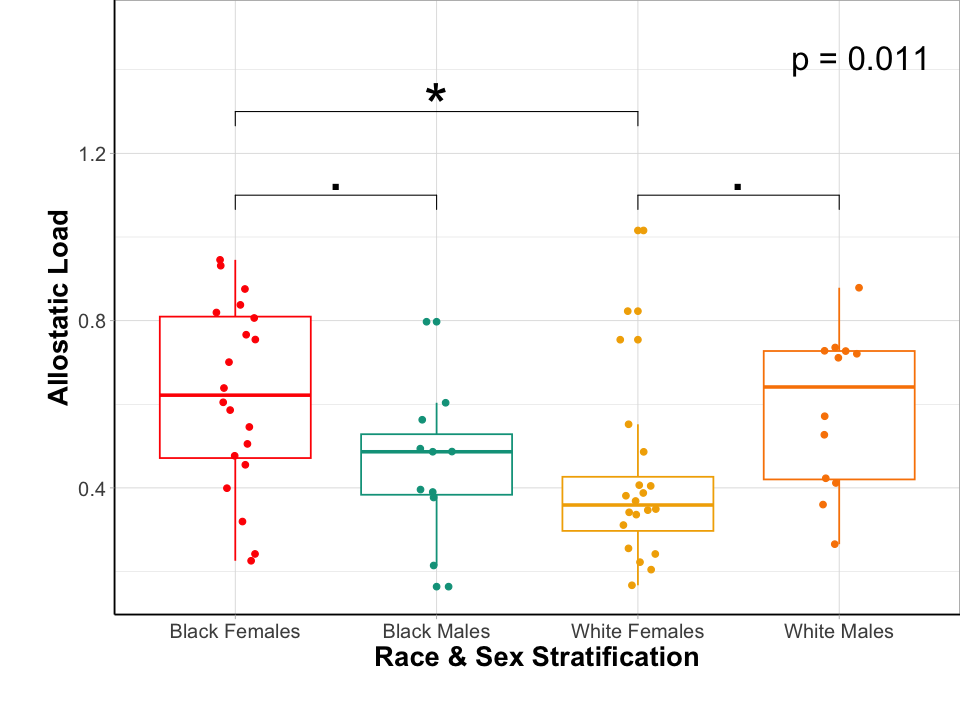

In [31]:
options(repr.plot.width=8, repr.plot.height=6) #changing size

col_palette1 = wes_palette("Darjeeling1", 4, type = "discrete")

fig3g = ggplot(data = cleaned_three_df, aes(x = Race_Sex, y = Allostatic_Load, color = Race_Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.5) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race_Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 1.4, label.x = 3.9) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_AL_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Race & Sex Stratification', y = 'Allostatic Load') + #changing axis labels 
  scale_colour_manual(values = col_palette1) 

fig3g

### Smoking Status & Race Boxplot

In [32]:
t_test_p_values_AL_smoking_race = compare_means(Allostatic_Load ~ Smoking_Status_Race, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1.1, 1, 1.4, 1, 1.2))

# changing to match p adj above
t_test_p_values_AL_smoking_race[2,7] = '.'
t_test_p_values_AL_smoking_race[4,7] = '*'
t_test_p_values_AL_smoking_race[6,7] = '*'

t_test_p_values_AL_smoking_race

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,White NS,White CS,0.68258023,0.850,0.683,ns,T-test,1.0
Allostatic_Load,White NS,Black NS,0.06666548,0.130,0.067,.,T-test,1.1
Allostatic_Load,White NS,Black CS,0.71157718,0.850,0.712,ns,T-test,1.0
Allostatic_Load,White CS,Black NS,0.02163149,0.065,0.022,*,T-test,1.4
Allostatic_Load,White CS,Black CS,0.91892614,0.920,0.919,ns,T-test,1.0
Allostatic_Load,Black NS,Black CS,0.01596478,0.065,0.016,*,T-test,1.2


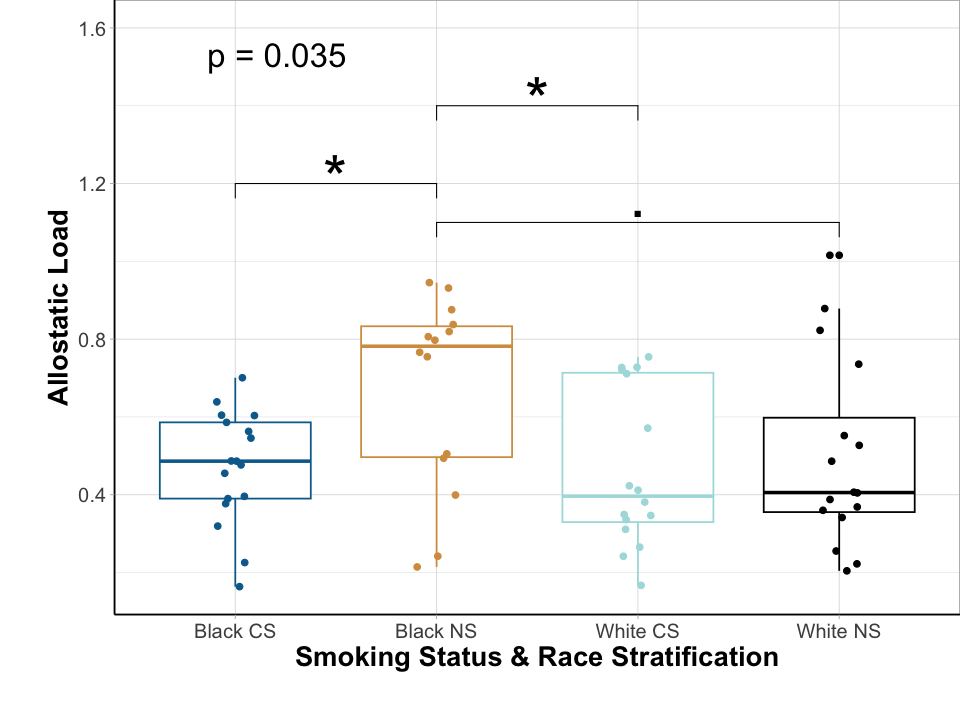

In [33]:
col_palette2 = wes_palette("Darjeeling2", 5, type = "discrete")

fig3h = ggplot(data = cleaned_three_df, aes(x = Smoking_Status_Race, y = Allostatic_Load, color = Smoking_Status_Race)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1.6) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Smoking_Status_Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.5) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_AL_smoking_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Smoking Status & Race Stratification', y = 'Allostatic Load') + #changing axis labels 
  scale_colour_manual(values = col_palette2[2:5])

fig3h

### Sex & Smoking Status

In [34]:
t_test_p_values_AL_smoking_sex = compare_means(Allostatic_Load ~ Sex_Smoking_Status, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 1, 0.7, 0.9))

t_test_p_values_AL_smoking_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,Male NS,Female NS,0.94146998,0.94,0.941,ns,T-test,1.0
Allostatic_Load,Male NS,Male CS,0.50140126,0.60,0.501,ns,T-test,1.0
Allostatic_Load,Male NS,Female CS,0.21587644,0.44,0.216,ns,T-test,1.0
Allostatic_Load,Female NS,Male CS,0.26774756,0.44,0.268,ns,T-test,1.0
Allostatic_Load,Female NS,Female CS,0.04841955,0.29,0.048,ns,T-test,0.7
Allostatic_Load,Male CS,Female CS,0.29657520,0.44,0.297,ns,T-test,0.9


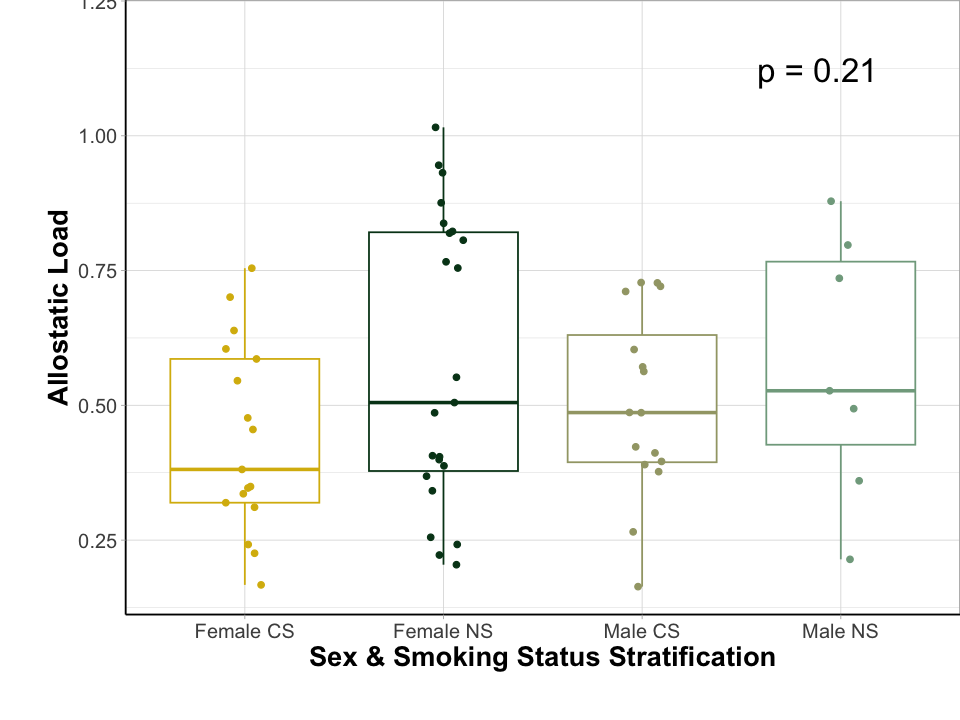

In [35]:
col_palette3 = wes_palette("Cavalcanti1", 4, type = "discrete")

fig3i = ggplot(data = cleaned_three_df, aes(x = Sex_Smoking_Status, y = Allostatic_Load, color = Sex_Smoking_Status)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.2) + 

  # overall anova p value
  stat_anova_test(wid = "Sex_Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 1.1, label.x = 3.7) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_AL_smoking_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Sex & Smoking Status Stratification', y = 'Allostatic Load') + #changing axis labels 
  scale_colour_manual(values = col_palette3)

fig3i

## Acute Stress

In [36]:
# calling anova fn
three_anova_smoking_acute = t_test_output(three_df, 'Smoking_Status','Acute_Stress', "Three")
three_anova_sex_acute = t_test_output(three_df, 'Sex', 'Acute_Stress', "Three")
three_anova_race_acute = t_test_output(three_df, 'Race', 'Acute_Stress', "Three")
two_anova_smoking_acute = t_test_output(two_df, 'Smoking_Status', 'Acute_Stress', "Two")
two_anova_sex_acute = t_test_output(two_df, 'Sex', 'Acute_Stress', "Two")
two_anova_race_acute = t_test_output(two_df, 'Race', 'Acute_Stress', "Two")

# creating 1 df
acute_t_test_df = unique(rbind(three_anova_smoking_acute, three_anova_sex_acute,
                            three_anova_race_acute, two_anova_smoking_acute, 
                              two_anova_sex_acute, two_anova_race_acute)) 

Running stratified statistical tests.

In [37]:
# calling fn
three_anova_smoking_race_acute = get_anova(three_df, 'Smoking_Status:Race', 'Acute_Stress', "Three")
three_anova_smoking_sex_acute = get_anova(three_df, 'Sex:Smoking_Status', 'Acute_Stress', "Three")
three_anova_sex_race_acute = get_anova(three_df, 'Race:Sex', 'Acute_Stress', "Three")
two_anova_smoking_race_acute = get_anova(two_df, 'Smoking_Status:Race', 'Acute_Stress', "Two")
two_anova_smoking_sex_acute = get_anova(two_df, 'Sex:Smoking_Status', 'Acute_Stress', "Two")
two_anova_sex_race_acute = get_anova(two_df, 'Race:Sex', 'Acute_Stress', "Two")

# creating 1 df
acute_anova_df = unique(rbind(three_anova_smoking_race_acute, three_anova_smoking_sex_acute,
                            three_anova_sex_race_acute, two_anova_smoking_race_acute, two_anova_smoking_sex_acute,
                            two_anova_sex_race_acute))

In [38]:
# viewing sig results
acute_t_test_df %>%
    filter(P_Value < 0.1) 

acute_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Variable,Difference,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
Acute_Stress,Three,Smoking_Status,-0.07480715,0.03471492
Acute_Stress,Two,Smoking_Status,-0.06964711,0.03832612


Outcome,BP_Class,Variable,F_Value,P_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>


There are differences in smoking status, and stratification of sex and smoking status and race and sex.

In [39]:
# calling fn
three_t_test_smoking_race_acute = t_test_output(three_df, 'Smoking_Status','Acute_Stress', "Three")
three_t_test_smoking_sex_acute = t_test_output(three_df, 'Sex','Acute_Stress', "Three")
three_t_test_sex_race_acute = t_test_output(three_df, 'Race', 'Acute_Stress', "Three")
two_t_test_smoking_race_acute = t_test_output(two_df, 'Smoking_Status',  'Acute_Stress', "Two")
two_t_test_smoking_sex_acute = t_test_output(two_df, 'Sex', 'Acute_Stress',  "Two")
two_t_test_sex_race_acute = t_test_output(two_df, 'Race',  'Acute_Stress', "Two")

# creating 1 df
acute_t_test_df = unique(rbind(three_t_test_smoking_race_acute, three_t_test_smoking_sex_acute,
                            three_t_test_sex_race_acute, two_t_test_smoking_race_acute, 
                            two_t_test_smoking_sex_acute, two_t_test_sex_race_acute))

In [40]:
# calling fn
three_t_test_smoking_race_acute = pairwise_t_test_output(three_df, 'Smoking_Status:Race', 'Acute_Stress', "Three")
three_t_test_smoking_sex_acute = pairwise_t_test_output(three_df,'Sex:Smoking_Status', 'Acute_Stress', "Three")
three_t_test_sex_race_acute = pairwise_t_test_output(three_df,'Race:Sex', 'Acute_Stress', "Three")
two_t_test_smoking_race_acute = pairwise_t_test_output(two_df, 'Smoking_Status:Race', 'Acute_Stress', "Two")
two_t_test_smoking_sex_acute = pairwise_t_test_output(two_df, 'Sex:Smoking_Status', 'Acute_Stress',  "Two")
two_t_test_sex_race_acute = pairwise_t_test_output(two_df, 'Race:Sex', 'Acute_Stress', "Two")

# creating 1 df
acute_pairwise_t_test_df = unique(rbind(three_t_test_smoking_race_acute, three_t_test_smoking_sex_acute,
                            three_t_test_sex_race_acute, two_t_test_smoking_race_acute, two_t_test_smoking_sex_acute,
                            two_t_test_sex_race_acute)) 

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [41]:
# viewing sig pairwise results
acute_pairwise_t_test_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Stratified_Variable,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>


Again plotting weights based on 3 class prediction since there were more differences.

### Race & Sex Boxplot

In [42]:
t_test_p_values_acute_race_sex = compare_means(Acute_Stress ~ Race_Sex, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(0.9, 1.1, 1, 1, 1, 1))

t_test_p_values_acute_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,White Males,White Females,0.13487891,0.30,0.135,ns,T-test,0.9
Acute_Stress,White Males,Black Females,0.32237868,0.45,0.322,ns,T-test,1.1
Acute_Stress,White Males,Black Males,0.07229472,0.30,0.072,ns,T-test,1.0
Acute_Stress,White Females,Black Females,0.37241614,0.45,0.372,ns,T-test,1.0
Acute_Stress,White Females,Black Males,0.59746204,0.60,0.597,ns,T-test,1.0
Acute_Stress,Black Females,Black Males,0.15008365,0.30,0.150,ns,T-test,1.0


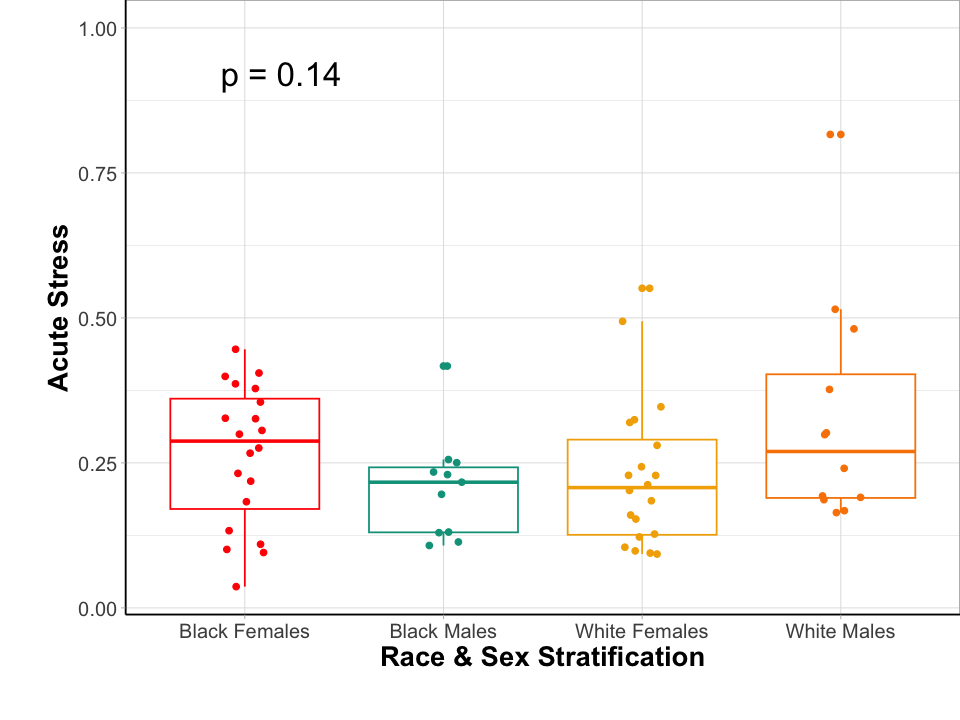

In [43]:
fig3a = ggplot(data = cleaned_three_df, aes(x = Race_Sex, y = Acute_Stress, color = Race_Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race_Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 0.9) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_acute_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Race & Sex Stratification', y = 'Acute Stress') + #changing axis labels 
  scale_colour_manual(values = col_palette1)

fig3a

### Smoking Status & Race Boxplot

In [44]:
t_test_p_values_acute_smoking_race = compare_means(Acute_Stress ~ Smoking_Status_Race, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1.4, 1, 1.7, 1, 1.5))

t_test_p_values_acute_smoking_race

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,White NS,White CS,0.36111615,0.43,0.36,ns,T-test,1.0
Acute_Stress,White NS,Black NS,0.94171284,0.94,0.94,ns,T-test,1.4
Acute_Stress,White NS,Black CS,0.08962844,0.27,0.09,ns,T-test,1.0
Acute_Stress,White CS,Black NS,0.22124040,0.43,0.22,ns,T-test,1.7
Acute_Stress,White CS,Black CS,0.33021133,0.43,0.33,ns,T-test,1.0
Acute_Stress,Black NS,Black CS,0.02037567,0.12,0.02,ns,T-test,1.5


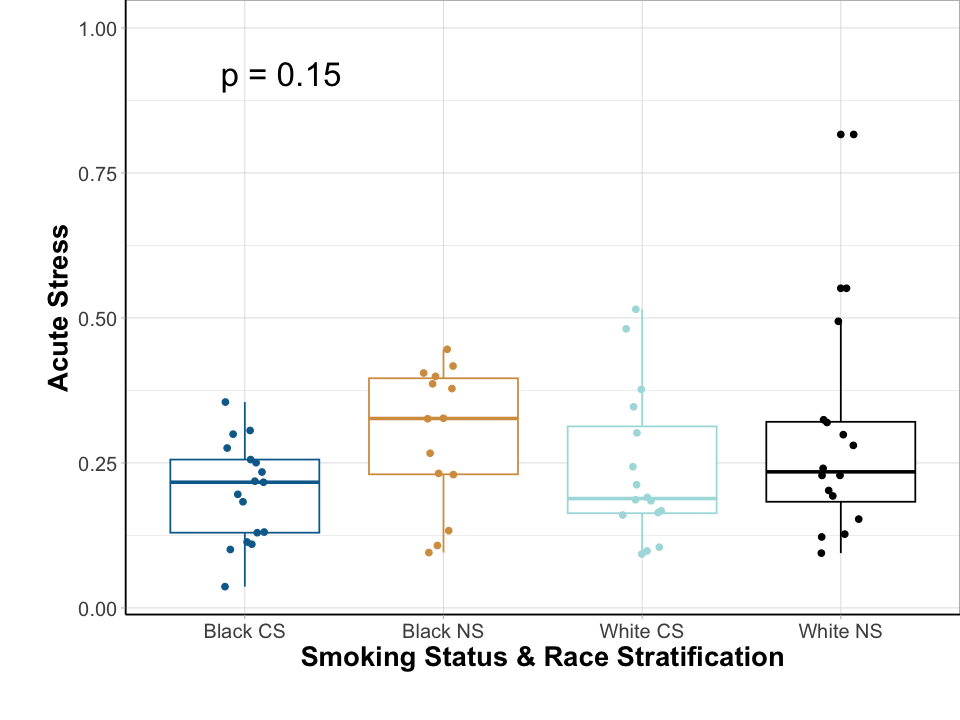

In [45]:
fig3b = ggplot(data = cleaned_three_df, aes(x = Smoking_Status_Race, y = Acute_Stress, color = Smoking_Status_Race)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Smoking_Status_Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 0.9) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_acute_smoking_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Smoking Status & Race Stratification', y = 'Acute Stress') + #changing axis labels 
  scale_colour_manual(values = col_palette2[2:5])

fig3b

### Sex & Smoking Status Boxplot

In [46]:
t_test_p_values_acute_smoking_sex = compare_means(Acute_Stress ~ Sex_Smoking_Status, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 1, 0.7, 0.9))

t_test_p_values_acute_smoking_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,Male NS,Female NS,0.63904819,0.64,0.64,ns,T-test,1.0
Acute_Stress,Male NS,Male CS,0.39518111,0.47,0.40,ns,T-test,1.0
Acute_Stress,Male NS,Female CS,0.19116499,0.42,0.19,ns,T-test,1.0
Acute_Stress,Female NS,Male CS,0.34002537,0.47,0.34,ns,T-test,1.0
Acute_Stress,Female NS,Female CS,0.01958891,0.12,0.02,ns,T-test,0.7
Acute_Stress,Male CS,Female CS,0.21221316,0.42,0.21,ns,T-test,0.9


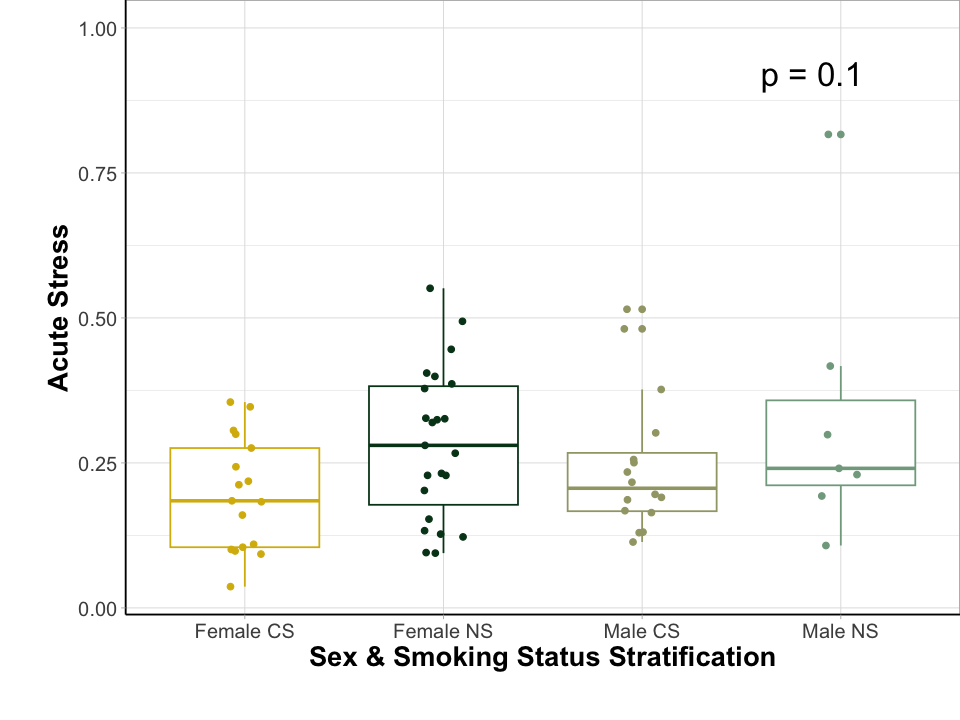

In [47]:
fig3c = ggplot(data = cleaned_three_df, aes(x = Sex_Smoking_Status, y = Acute_Stress, color = Sex_Smoking_Status)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1) + 

  # overall anova p value
  stat_anova_test(wid = "Sex_Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 0.9, label.x = 3.7) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_acute_smoking_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Sex & Smoking Status Stratification', y = 'Acute Stress') + #changing axis labels 
  scale_colour_manual(values = col_palette3)

fig3c

## Chronic Stress

In [48]:
# calling anova fn
anova_smoking_chronic = t_test_output(three_df, 'Smoking_Status','Chronic_Stress', NA)
anova_sex_chronic = t_test_output(three_df, 'Sex', 'Chronic_Stress', NA)
anova_race_chronic = t_test_output(three_df, 'Race', 'Chronic_Stress', NA)

# creating 1 df
chronic_t_test_df = unique(rbind(anova_smoking_chronic, anova_sex_chronic, anova_race_chronic)) 

In [49]:
# calling fn
anova_smoking_race_chronic = get_anova(three_df, 'Smoking_Status:Race', 'Chronic_Stress', NA)
anova_smoking_sex_chronic = get_anova(three_df, 'Sex:Smoking_Status', 'Chronic_Stress', NA)
anova_sex_race_chronic = get_anova(three_df, 'Race:Sex', 'Chronic_Stress', NA)

# creating 1 df
chronic_anova_df = unique(rbind(anova_smoking_race_chronic, anova_smoking_sex_chronic,
                            anova_sex_race_chronic))

In [50]:
# viewing sig results
chronic_t_test_df %>%
    filter(P_Value < 0.1)

chronic_anova_df %>%
    filter(P_Value < 0.1)

Outcome,BP_Class,Variable,Difference,P_Value
<chr>,<lgl>,<chr>,<dbl>,<dbl>
Chronic_Stress,NA,Race,0.1015815,0.009811123


Outcome,BP_Class,Variable,F_Value,P_Value
<chr>,<lgl>,<chr>,<dbl>,<dbl>
Chronic_Stress,NA,Smoking_Status:Race,3.728747,0.015972625
Chronic_Stress,NA,Race:Sex,4.546186,0.006214545


There is a significant difference in chronic stress across racial groups (p value < 0.05). Significant differences are present when stratified between smoking status and race along with race and sex.

In [51]:
# calling fn
t_test_smoking_race_chronic = pairwise_t_test_output(three_df, 'Smoking_Status:Race', 'Chronic_Stress', NA)
t_test_smoking_sex_chronic = pairwise_t_test_output(three_df, 'Sex:Smoking_Status', 'Chronic_Stress', NA)
t_test_sex_race_chronic = pairwise_t_test_output(three_df, 'Race:Sex', 'Chronic_Stress', NA)

# creating 1 df
chronic_pairwise_t_test_df = unique(rbind(t_test_smoking_race_chronic, t_test_smoking_sex_chronic,
                            t_test_sex_race_chronic)) 

Using group1 as id variables

Using group1 as id variables

Using group1 as id variables



In [52]:
# viewing sig pairwise results
chronic_pairwise_t_test_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Stratified_Variable,Variable1,Variable2,Difference,P_Value,P_Adj
<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Chronic_Stress,NA,Smoking_Status:Race,NS:B,CS:W,-0.1480153,0.0085897288,0.025769186
Chronic_Stress,NA,Smoking_Status:Race,NS:W,NS:B,0.1683331,0.0030338956,0.018203374
Chronic_Stress,NA,Race:Sex,W:F,B:F,0.1685068,0.0005680924,0.003408555


### Race & Sex Boxplot

In [53]:
t_test_p_values_chronic_race_sex = compare_means(Chronic_Stress ~ Race_Sex, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 0.75, 1, 1))

t_test_p_values_chronic_race_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,White Males,White Females,0.166445263,0.2500,0.1664,ns,T-test,1.00
Chronic_Stress,White Males,Black Females,0.064645064,0.1300,0.0646,ns,T-test,1.00
Chronic_Stress,White Males,Black Males,0.770877232,0.7700,0.7709,ns,T-test,1.00
Chronic_Stress,White Females,Black Females,0.001389908,0.0083,0.0014,**,T-test,0.75
Chronic_Stress,White Females,Black Males,0.306787309,0.3700,0.3068,ns,T-test,1.00
Chronic_Stress,Black Females,Black Males,0.043933900,0.1300,0.0439,ns,T-test,1.00


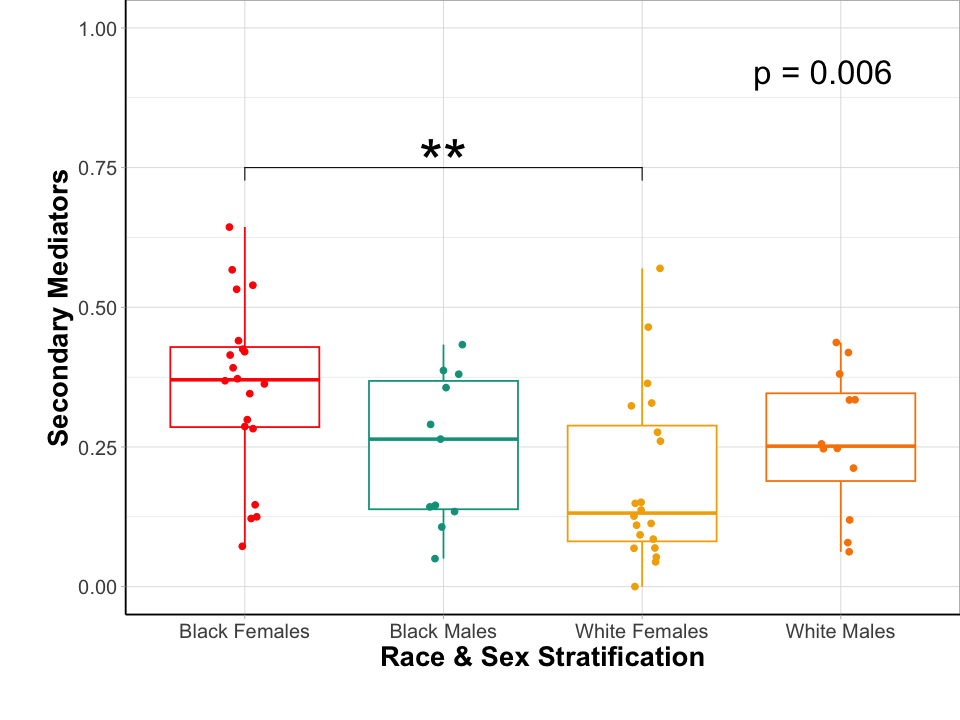

In [54]:
fig3d = ggplot(data = cleaned_three_df, aes(x = Race_Sex, y = Chronic_Stress, color = Race_Sex)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 
  ylim(NA, 1) + # adding more space for p value significance

  # overall anova p value
  stat_anova_test(wid = "Race_Sex", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 0.9, label.x = 3.7) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_chronic_race_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Race & Sex Stratification', y = 'Secondary Mediators') + #changing axis labels 
  scale_colour_manual(values = col_palette1)

fig3d

### Smoking Status & Race Boxplot

In [55]:
t_test_p_values_chronic_smoking_race = compare_means(Chronic_Stress ~ Smoking_Status_Race, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 0.7, 1, 0.9, 1, 1))

# changing to match p adj above
t_test_p_values_chronic_smoking_race[2,7] = '*'
t_test_p_values_chronic_smoking_race[4,7] = '*'

t_test_p_values_chronic_smoking_race

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,White NS,White CS,0.700892880,0.700,0.7009,ns,T-test,1.0
Chronic_Stress,White NS,Black NS,0.008928662,0.054,0.0089,*,T-test,0.7
Chronic_Stress,White NS,Black CS,0.184187749,0.280,0.1842,ns,T-test,1.0
Chronic_Stress,White CS,Black NS,0.019778514,0.059,0.0198,*,T-test,0.9
Chronic_Stress,White CS,Black CS,0.357782622,0.430,0.3578,ns,T-test,1.0
Chronic_Stress,Black NS,Black CS,0.076513737,0.150,0.0765,ns,T-test,1.0


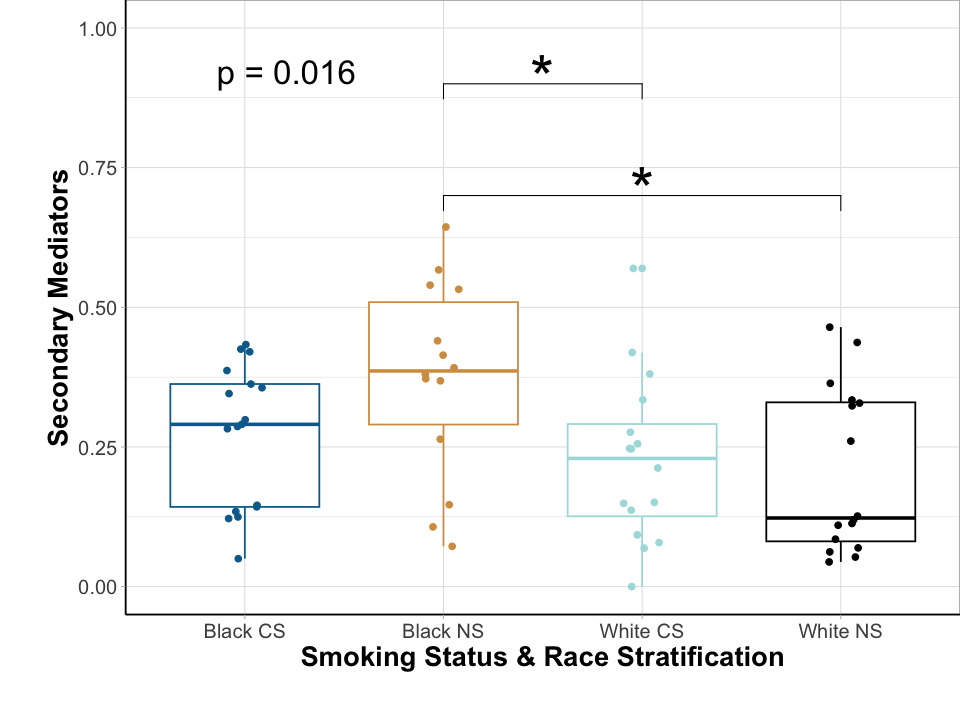

In [56]:
fig3e = ggplot(data = cleaned_three_df, aes(x = Smoking_Status_Race, y = Chronic_Stress, color = Smoking_Status_Race)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1) + 

  # overall anova p value
  stat_anova_test(wid = "Smoking_Status_Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 0.9) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_chronic_smoking_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Smoking Status & Race Stratification', y = 'Secondary Mediators')  + #changing axis labels 
  scale_colour_manual(values = col_palette2[2:5])

fig3e

### Sex & Smoking Status

In [57]:
t_test_p_values_chronic_smoking_sex = compare_means(Chronic_Stress ~ Sex_Smoking_Status, data = cleaned_three_df, 
                                         method = "t.test", p.adjust.method = 'fdr') %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1, 1, 1, 0.7, 0.9))

t_test_p_values_chronic_smoking_sex

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,Male NS,Female NS,0.4489821,0.90,0.45,ns,T-test,1.0
Chronic_Stress,Male NS,Male CS,0.8340610,0.98,0.83,ns,T-test,1.0
Chronic_Stress,Male NS,Female CS,0.9828299,0.98,0.98,ns,T-test,1.0
Chronic_Stress,Female NS,Male CS,0.4300331,0.90,0.43,ns,T-test,1.0
Chronic_Stress,Female NS,Female CS,0.3158904,0.90,0.32,ns,T-test,0.7
Chronic_Stress,Male CS,Female CS,0.7536269,0.98,0.75,ns,T-test,0.9


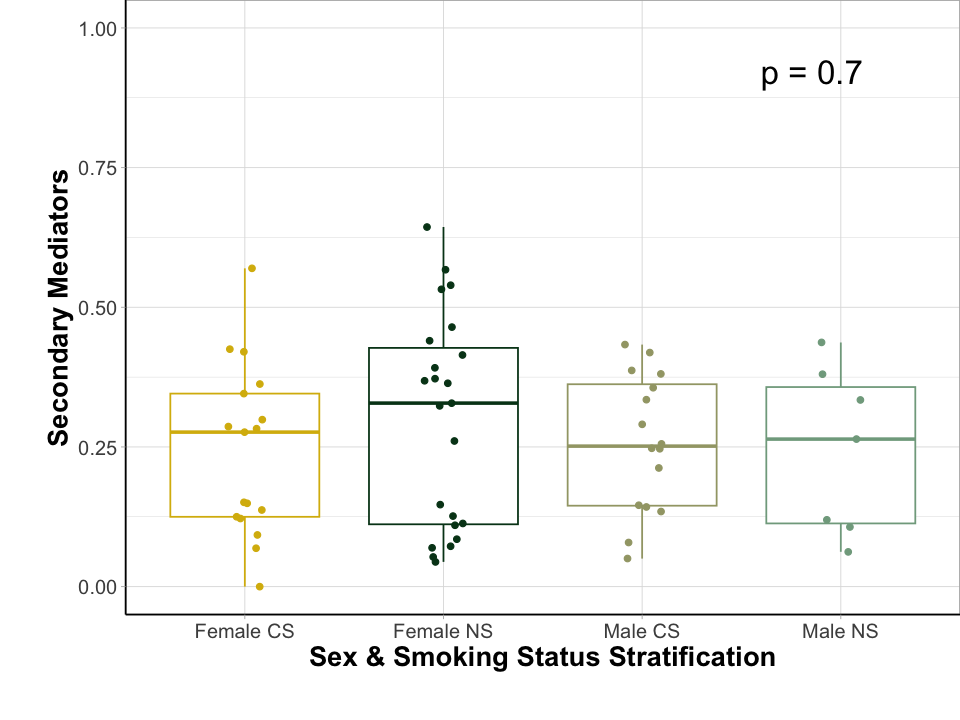

In [58]:
fig3f = ggplot(data = cleaned_three_df, aes(x = Sex_Smoking_Status, y = Chronic_Stress, color = Sex_Smoking_Status)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1) + 

  # overall anova p value
  stat_anova_test(wid = "Sex_Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "right", size = 7, label.y = 0.9, label.x = 3.7) +

  # adjusted p value
  stat_pvalue_manual(t_test_p_values_chronic_smoking_sex %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 13) + 

theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5))) + #changes axis titles
         
  labs(x = 'Sex & Smoking Status Stratification', y = 'Secondary Mediators') + #changing axis labels 
  scale_colour_manual(values = col_palette3)

fig3f

# Recap of Significant Results
**Overall AL**
+ *Race*
    + black subjects had a higher AL than white subjects
+ *Smoking Status*
    + non-smokers had higher AL than cigarette smokers
+ *Smoking Status and Race*
    + black NS had a higher AL than all other groups
+ *Sex and Race*
    + black females have a higher AL than white females and black men
    + white men had a higher AL than white females

**Acute Stress**
+ *Smoking Status*
    + non-smokers had higher acute stress than cigarette smokers

**Chronic Stress**
+ *Race*
    + black subjects have higher chronic stress than white subjects
+ *Smoking Status and Race*
    + black NS had higher levels of chronic stress than both white NS and white CS
+ *Sex and Race*
    + black females have a higher chronic stress than white females
 

Visualizing distributions of stress scores across each group, but first combining dataframes.

In [59]:
# combining dfs for export
t_test_df = rbind(allostatic_t_test_df, acute_t_test_df, chronic_t_test_df)
anova_df = rbind(allostatic_anova_df, acute_anova_df, chronic_anova_df)
pairwise_t_test_df = rbind(allostatic_pairwise_t_test_df, acute_pairwise_t_test_df, chronic_pairwise_t_test_df)
subject_scores_df = inner_join(allostatic_three_df %>%
                              rename(Acute_Stress_Three = Acute_Stress, Allostatic_Load_Three = Allostatic_Load), 
                              allostatic_two_df %>%
                              rename(Acute_Stress_Two = Acute_Stress, Allostatic_Load_Two = Allostatic_Load))

head(t_test_df)
head(anova_df)
head(pairwise_t_test_df)
head(subject_scores_df)

Joining with `by = join_by(Subject_ID, Chronic_Stress)`


,Outcome,BP_Class,Variable,Difference,P_Value
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Allostatic_Load,Three,Smoking_Status,-0.109957339,0.05446881
2,Allostatic_Load,Three,Sex,0.003331139,0.95216577
3,Allostatic_Load,Three,Race,0.079820431,0.15633827
4,Allostatic_Load,Two,Smoking_Status,-0.104797299,0.06296185
5,Allostatic_Load,Two,Sex,-0.018447814,0.72832241
6,Allostatic_Load,Two,Race,0.077809345,0.16002138


,Outcome,BP_Class,Variable,F_Value,P_Value
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Allostatic_Load,Three,Smoking_Status:Race,3.051647,0.03540854
2,Allostatic_Load,Three,Sex:Smoking_Status,1.546849,0.21189458
3,Allostatic_Load,Three,Race:Sex,4.036517,0.01116831
4,Allostatic_Load,Two,Smoking_Status:Race,3.080984,0.03420045
5,Allostatic_Load,Two,Sex:Smoking_Status,1.656668,0.18612273
6,Allostatic_Load,Two,Race:Sex,2.641410,0.05762773


,Outcome,BP_Class,Stratified_Variable,Variable1,Variable2,Difference,P_Value,P_Adj
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Allostatic_Load,Three,Smoking_Status:Race,CS:W,CS:B,0.006357896,0.93177133,0.93177133
2,Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:B,-0.198890979,0.01188703,0.03566109
3,Allostatic_Load,Three,Smoking_Status:Race,NS:W,CS:B,-0.026360499,0.72274311,0.86729173
4,Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:W,-0.205248874,0.01053862,0.03566109
5,Allostatic_Load,Three,Smoking_Status:Race,NS:W,CS:W,-0.032718395,0.66448553,0.86729173
6,Allostatic_Load,Three,Smoking_Status:Race,NS:W,NS:B,0.172530480,0.03022035,0.06044070


,Subject_ID,Acute_Stress_Three,Chronic_Stress,Allostatic_Load_Three,Acute_Stress_Two,Allostatic_Load_Two
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NS_M_28_W_51,0.8163546,0.06229179,0.8786464,0.6682219,0.7305137
2,NS_F_23_W_41,0.5511180,0.46449188,1.0156099,0.6426752,1.1071671
3,CS_M_28_W_16,0.5149280,0.21225869,0.7271867,0.4562134,0.6684721
4,NS_F_21_W_38,0.4941965,0.32846096,0.8226575,0.6363093,0.9647703
5,CS_M_29_W_17,0.4811360,0.24664702,0.7277830,0.5242166,0.7708636
6,NS_F_32_B_57,0.4459038,0.39174739,0.8376512,0.4543321,0.8460795


In [60]:
longer_subject_scores_df = subject_scores_df %>%
    pivot_longer(cols = 2:6, names_to = "Variable", values_to = "Value") %>%
    # removing the scores that are based on the two class weights
    filter(!grepl("Two", Variable)) %>%
    # adding a col that specifies the group
    inner_join(subject_info_df[,c(3,5:8)]) %>%
    # cleaning up names
    mutate(Variable = gsub("_Three", "", Variable),
          Variable = gsub("_", " ", Variable),
          Smoking_Status = ifelse(Smoking_Status == 'NS', "Non-Smokers", "Cigarette Smokers"),
          Sex = ifelse(Sex == 'M', "Males", "Females"),
          Race = ifelse(Race == 'W', "White", "Black")) %>%
    # changing name of chronic stress
    mutate(Variable = ifelse(Variable == 'Chronic Stress', 'Secondary Mediators', Variable))

# putting variables into a factor for ordering
longer_subject_scores_df$Variable = factor(longer_subject_scores_df$Variable, 
                                           levels = c("Acute Stress", "Secondary Mediators", "Allostatic Load"))
longer_subject_scores_df$Sex = factor(longer_subject_scores_df$Sex, 
                                           levels = c("Females", "Males"))
longer_subject_scores_df$Smoking_Status = factor(longer_subject_scores_df$Smoking_Status, 
                                           levels = c("Non-Smokers", "Cigarette Smokers"))

head(longer_subject_scores_df)

Joining with `by = join_by(Subject_ID)`


Subject_ID,Variable,Value,Smoking_Status,Sex,Age,Race
<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>
NS_M_28_W_51,Acute Stress,0.81635460,Non-Smokers,Males,28,White
NS_M_28_W_51,Secondary Mediators,0.06229179,Non-Smokers,Males,28,White
NS_M_28_W_51,Allostatic Load,0.87864639,Non-Smokers,Males,28,White
NS_F_23_W_41,Acute Stress,0.55111797,Non-Smokers,Females,23,White
NS_F_23_W_41,Secondary Mediators,0.46449188,Non-Smokers,Females,23,White
NS_F_23_W_41,Allostatic Load,1.01560985,Non-Smokers,Females,23,White


### Variable Boxplots

In [61]:
stat_test_race = longer_subject_scores_df %>%
    group_by(Variable) %>%
    t_test(Value ~ Race) %>%
    add_significance(cutpoints = c(0, 1e-04, 0.001, 0.01, 0.05, 0.1, 1),
                    symbols = c("****", "***", "**", "*", ".", "ns")) %>%
    # manually adding the y position
    mutate(y.position = c(1, 0.8, 1.4))

stat_test_sex = longer_subject_scores_df %>%
    group_by(Variable) %>%
    t_test(Value ~ Sex) %>%
    add_significance(cutpoints = c(0, 1e-04, 0.001, 0.01, 0.05, 0.1, 1),
                    symbols = c("****", "***", "**", "*", ".", "ns")) %>%
    # manually adding the y position
    mutate(y.position = c(1, 1.1, 1.4))

stat_test_smoking = longer_subject_scores_df %>%
    group_by(Variable) %>%
    t_test(Value ~ Smoking_Status) %>%
    add_significance(cutpoints = c(0, 1e-04, 0.001, 0.01, 0.05, 0.1, 1),
                    symbols = c("****", "***", "**", "*", ".", "ns")) %>%
    # manually adding the y position
    mutate(y.position = c(0.9, 1.1, 1.1))

stat_test_race

Variable,.y.,group1,group2,n1,n2,statistic,df,p,p.signif,y.position
<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Acute Stress,Value,Black,White,31,32,-0.6234694,55.49539,0.53600,ns,1.0
Secondary Mediators,Value,Black,White,31,32,2.6668380,60.43793,0.00981,**,0.8
Allostatic Load,Value,Black,White,31,32,1.4352142,60.94727,0.15600,ns,1.4


In [62]:
race_boxplots = ggplot(data = longer_subject_scores_df, aes(x = Race, y = Value)) + 
  geom_boxplot(aes(fill = Race, alpha = 0.8)) + 
  geom_point(position = position_jitter(w = 0.1)) + 
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1))) + # adds padding to y axis

  facet_wrap(~Variable, scale = 'free', ncol = 1) +

  # t test p value
  stat_pvalue_manual(stat_test_race %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 9) +

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5)),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes axis titles
         
   scale_fill_manual(values = c('#5ac394', '#a46ebb'))

sex_boxplots = ggplot(data = longer_subject_scores_df, aes(x = Sex, y = Value)) + 
  geom_boxplot(aes(fill = Sex, alpha = 0.8)) + 
  geom_point(position = position_jitter(w = 0.1)) + 

  facet_wrap(~Variable, scale = 'free', ncol = 1) +

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5)),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold"))  #changes axis titles

smoking_boxplots = ggplot(data = longer_subject_scores_df, aes(x = Smoking_Status, y = Value)) + 
  geom_boxplot(aes(fill = Smoking_Status, alpha = 0.8)) + 
  geom_point(position = position_jitter(w = 0.1)) + 
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1))) + # adds padding to y axis

  facet_wrap(~Variable, scale = 'free', ncol = 1) +

  # t test p value
  stat_pvalue_manual(stat_test_smoking %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 9) +

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        legend.position = 'none', # removes legend
        plot.margin = unit(c(0,0,2,2), "lines"), # adding space at the bottom of the figure
        axis.title = element_text(face = "bold", size = rel(1.5)),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes axis titles
         
   labs(x = 'Smoking Status') + #changing axis labels 
   scale_fill_manual(values = c('#b3669e', '#98984d'))

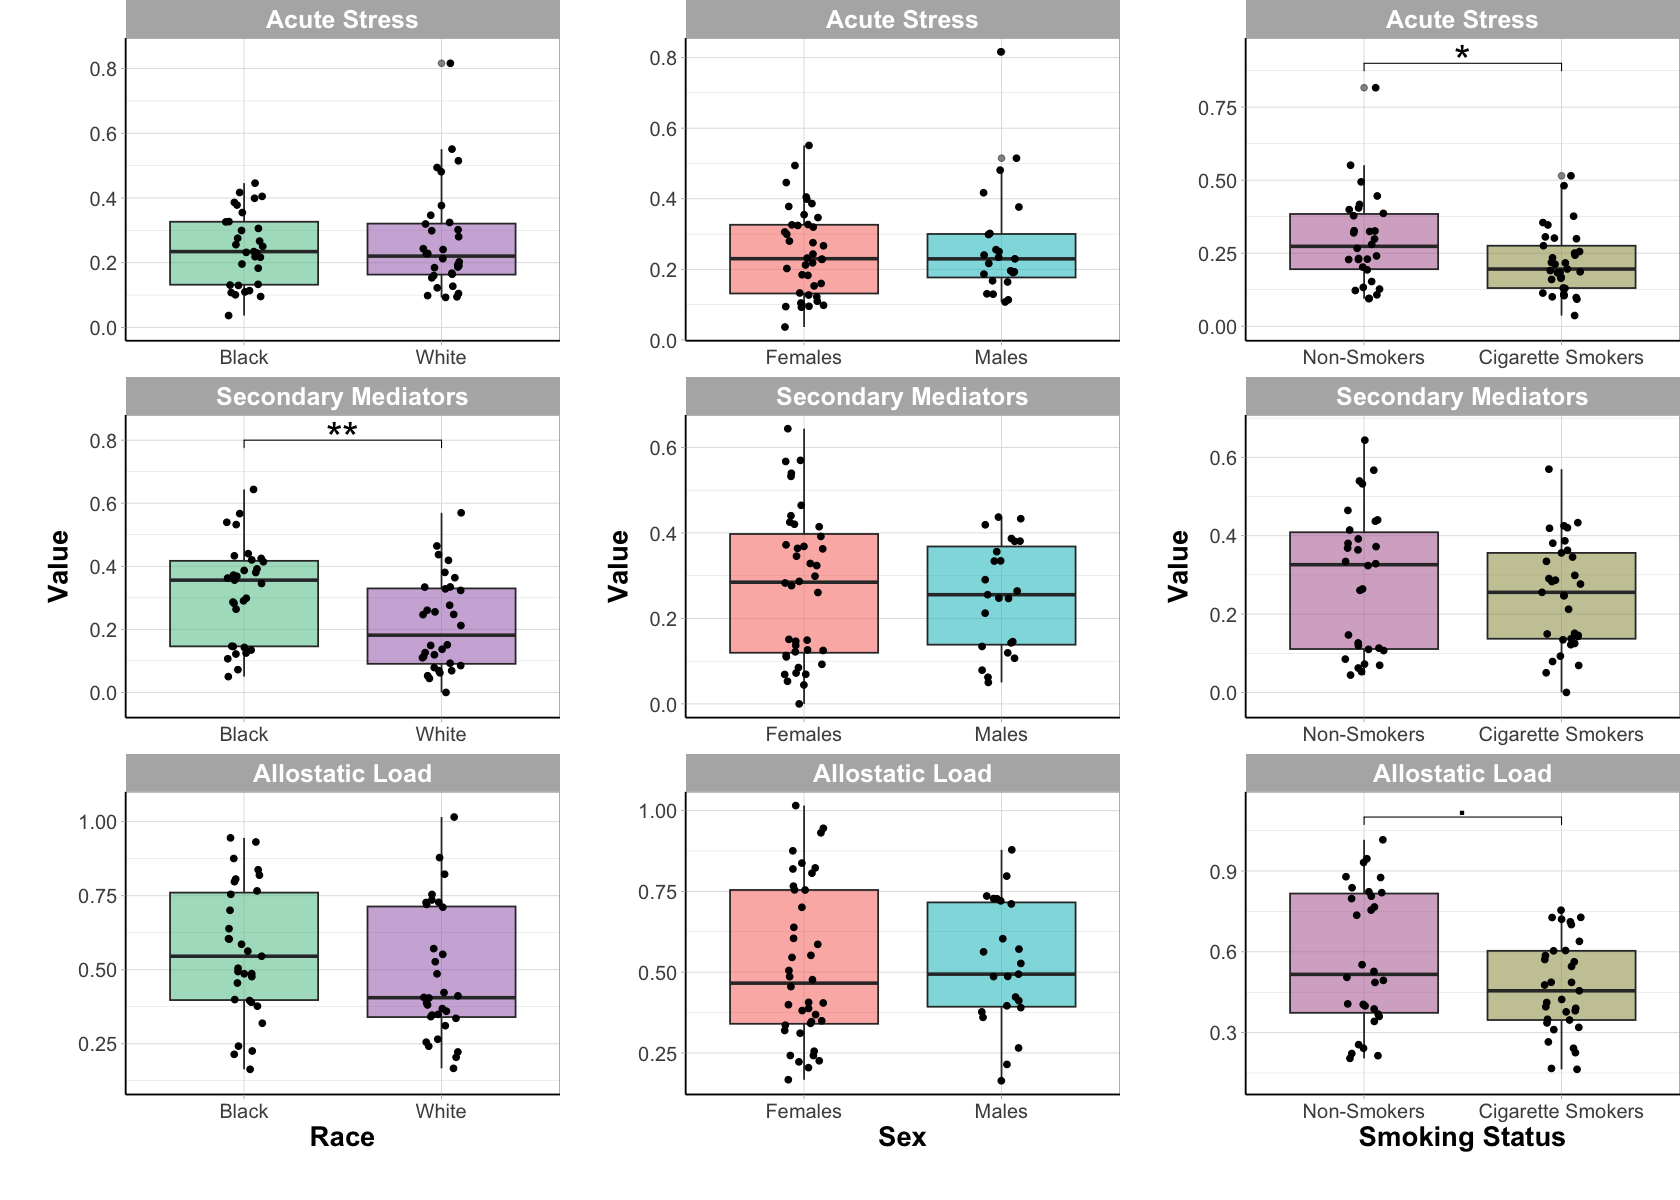

In [63]:
# combining plots for export
options(repr.plot.width = 14, repr.plot.height = 10) #changing size
Figure2 = plot_grid(race_boxplots, sex_boxplots, smoking_boxplots, nrow = 1)

Figure2

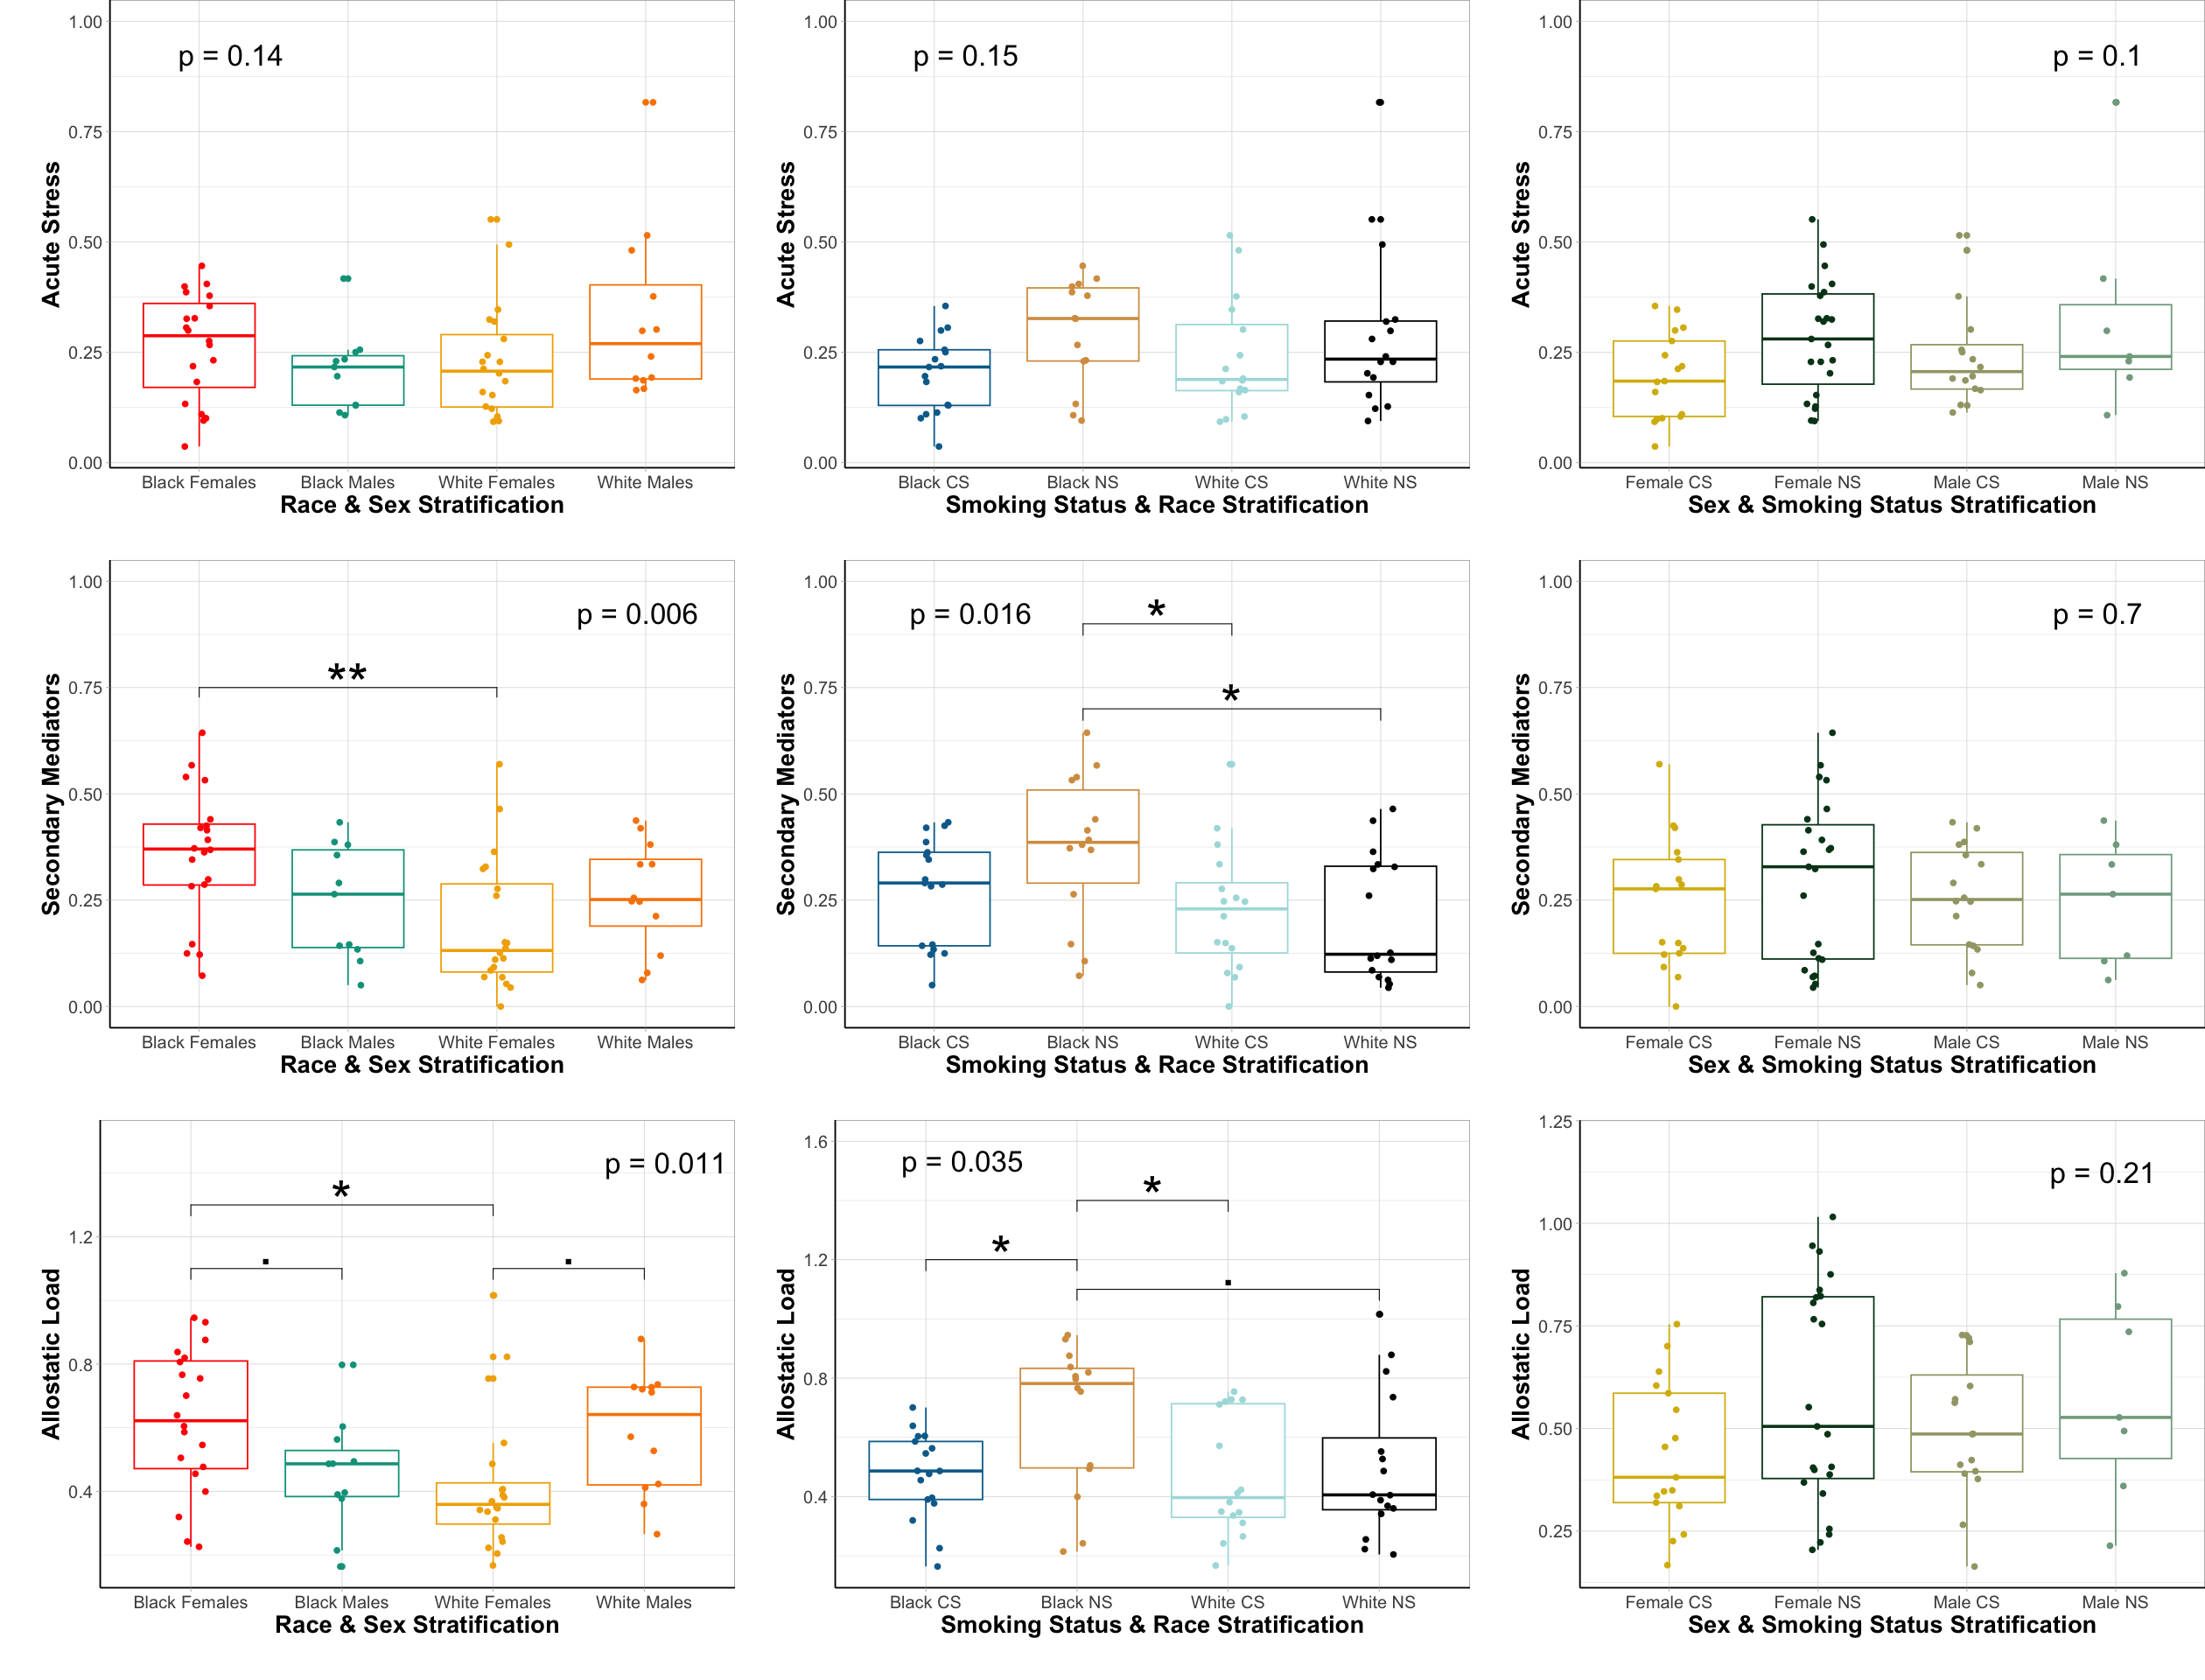

In [64]:
# combining plots for export
options(repr.plot.width = 21, repr.plot.height = 16) #changing size
Figure3 = plot_grid(fig3a,fig3b,fig3c,fig3d,fig3e,fig3f,fig3g,fig3h,fig3i, ncol = 3)

Figure3

In [65]:
# exporting
write.xlsx(subject_scores_df, paste0(Output,"/", "Allostatic_Subject_Scores_", cur_date, ".xlsx"), rowNames = FALSE)
write.xlsx(t_test_df, paste0(Output,"/", "T_test_Results_", cur_date, ".xlsx"), rowNames = FALSE) 
write.xlsx(anova_df, paste0(Output,"/", "ANOVA_Results_", cur_date, ".xlsx"), rowNames = FALSE) 
write.xlsx(pairwise_t_test_df, paste0(Output,"/", "Pairwise_t_test_Results_", cur_date, ".xlsx"), rowNames = FALSE) 

In [66]:
# exporting figures
ggsave(Figure1, 
       filename = 'Figure1.pdf',
       path = Output,
       width = 10, height = 10)

ggsave(Figure2, 
       filename = 'Figure2.pdf',
       path = Output,
       width = 14, height = 10)

ggsave(Figure3, 
       filename = 'Figure3.pdf',
       path = Output,
       width = 21, height = 16)